## Case Study #5 - Data Mart

#### Problem Statement

Data Mart is Danny’s latest venture and after running international operations for his online supermarket that specialises in fresh produce - Danny is asking for your support to analyse his sales performance.

In June 2020 - large scale supply changes were made at Data Mart. All Data Mart products now use sustainable packaging methods in every single step from the farm all the way to the customer.

Danny needs your help to quantify the impact of this change on the sales performance for Data Mart and it’s separate business areas.

The key business question he wants you to help him answer are the following:
- What was the quantifiable impact of the changes introduced in June 2020?
- Which platform, region, segment and customer types were the most impacted by this change?
- What can we do about future introduction of similar sustainability updates to the business to minimise impact on sales?

#### Entity Relationship Diagram

![week5.png](week5.png)

Import modules

In [1]:
# SQL Engine imports
from dotenv import load_dotenv
import os
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.sql import text
import warnings
warnings.filterwarnings("ignore")

# Python data analysis imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
pd.set_option('display.max_columns', None)

Initialize SQL

In [2]:
load_dotenv()
user = os.environ.get("USER")
pw = os.environ.get("PASS")
db = os.environ.get("DB")
host = os.environ.get("HOST")
api = os.environ.get("API")
port = 5432
schema = 'data_mart'

In [3]:
uri = f"postgresql+psycopg2://{user}:{pw}@{host}:{port}/{db}"
alchemyEngine = create_engine(uri)
conn = alchemyEngine.connect()

Verify tables

In [4]:
rs = conn.execute(text(f"SELECT table_name FROM information_schema.tables WHERE table_schema='{schema}'"))
tables = [table[0] for table in rs.fetchall()]
print(f'The tables in the database are: \n- {'\n- '.join(tables)}')

The tables in the database are: 
- weekly_sales


Fetch table information

In [5]:
for table in tables:
    print("=================================")
    print(f'Table [{table}]')
    df = pd.read_sql_query(f'SELECT * FROM {schema}.{table} LIMIT 5', conn)
    print(f'Dimensions: {df.shape[0]} rows x {df.shape[1]} columns\n')
    print(df.head())
    info_df = pd.DataFrame.from_dict({'Datatypes':df.dtypes, 'NULL count':df.isna().sum()})
    print()
    print(info_df)
    print()

Table [weekly_sales]
Dimensions: 5 rows x 7 columns

  week_date  region platform segment customer_type  transactions     sales
0   31/8/20    ASIA   Retail      C3           New        120631   3656163
1   31/8/20    ASIA   Retail      F1           New         31574    996575
2   31/8/20     USA   Retail    null         Guest        529151  16509610
3   31/8/20  EUROPE   Retail      C1           New          4517    141942
4   31/8/20  AFRICA   Retail      C2           New         58046   1758388

              Datatypes  NULL count
week_date        object           0
region           object           0
platform         object           0
segment          object           0
customer_type    object           0
transactions      int64           0
sales             int64           0



In [6]:
def query(stmt: str):
    """Executes a given SQL statement and returns a Pandas DataFrame given the results.
    
    Parameters
    ----------
    stmt: str
        The SQL statement to be executed
    """
    global conn
    result = pd.read_sql_query(stmt, conn)
    return result

## Case Study Questions

The following case study questions include some general data exploration analysis for the nodes and transactions before diving right into the core business questions and finishes with a challenging final request!

**A. Data Cleaning**

Q1: In a single query, perform the following operations and generate a new table in the `data_mart` schema named `clean_weekly_sales`:
- Convert the `week_date` to a DATE format
- Add a `week_number` as the second column for each `week_date` value, for example any value from the 1st of January to 7th of January will be 1, 8th to 14th will be 2 etc
- Add a `month_number` with the calendar month for each `week_date` value as the 3rd column
- Add a `calendar_year` column as the 4th column containing either 2018, 2019 or 2020 values
- Add a new column called `age_band` after the original `segment` column using the following mapping on the number inside the segment value:

<p align="center">
  <img src="week5a.png"/>
</p>

- Add a new `demographic` column using the following mapping for the first letter in the `segment` values:

<p align="center">
  <img src="week5b.png" />
</p>

- Ensure all `null` string values with an `"unknown"` string value in the original segment column as well as the new `age_band` and `demographic` columns
- Generate a new `avg_transaction` column as the `sales` value divided by `transactions` rounded to 2 decimal places for each record

In [7]:
conn.execute(text('''
  DROP TABLE IF EXISTS clean_weekly_sales;
  CREATE TEMP TABLE clean_weekly_sales AS (
  SELECT
    TO_DATE(week_date, 'DD/MM/YY') AS week_date,
    DATE_PART('week', TO_DATE(week_date, 'DD/MM/YY')) AS week_number,
    DATE_PART('month', TO_DATE(week_date, 'DD/MM/YY')) AS month_number,
    DATE_PART('year', TO_DATE(week_date, 'DD/MM/YY')) AS calendar_year,
    region, 
    platform, 
    segment,
    CASE 
      WHEN SUBSTRING(segment,2,1) = '1' THEN 'Young Adults'
      WHEN SUBSTRING(segment,2,1) = '2' THEN 'Middle Aged'
      WHEN SUBSTRING(segment,2,1) in ('3','4') THEN 'Retirees'
      ELSE 'unknown' END AS age_band,
    CASE 
      WHEN SUBSTRING(segment,1,1) = 'C' THEN 'Couples'
      WHEN SUBSTRING(segment,1,1) = 'F' THEN 'Families'
      ELSE 'unknown' END AS demographic,
    transactions,
    ROUND((sales::NUMERIC/transactions),2) AS avg_transaction,
    sales
  FROM data_mart.weekly_sales
  );
'''))

In [8]:
q1_df = query('SELECT * FROM clean_weekly_sales')
q1_df

,week_date,week_number,month_number,calendar_year,region,platform,segment,age_band,demographic,transactions,avg_transaction,sales
0,2020-08-31,36.0,8.0,2020.0,ASIA,Retail,C3,Retirees,Couples,120631,30.31,3656163
1,2020-08-31,36.0,8.0,2020.0,ASIA,Retail,F1,Young Adults,Families,31574,31.56,996575
2,2020-08-31,36.0,8.0,2020.0,USA,Retail,null,unknown,unknown,529151,31.20,16509610
3,2020-08-31,36.0,8.0,2020.0,EUROPE,Retail,C1,Young Adults,Couples,4517,31.42,141942
4,2020-08-31,36.0,8.0,2020.0,AFRICA,Retail,C2,Middle Aged,Couples,58046,30.29,1758388
...,...,...,...,...,...,...,...,...,...,...,...,...
17112,2018-03-26,13.0,3.0,2018.0,AFRICA,Retail,C3,Retirees,Couples,98342,37.69,3706066
17113,2018-03-26,13.0,3.0,2018.0,USA,Shopify,C4,Retirees,Couples,16,174.00,2784
17114,2018-03-26,13.0,3.0,2018.0,USA,Retail,F2,Middle Aged,Families,25665,41.46,1064172
17115,2018-03-26,13.0,3.0,2018.0,EUROPE,Retail,C4,Retirees,Couples,883,37.96,33523


**B. Data Exploration**

Q2: What day of the week is used for each `week_date` value?

In [9]:
query('''
    SELECT DISTINCT(TO_CHAR(week_date, 'day')) AS week_day 
    FROM clean_weekly_sales;
''')

,week_day
0,monday


Q3: What range of week numbers are missing from the dataset?

In [10]:
q3_df = query('''
    WITH week_number_cte AS (
        SELECT GENERATE_SERIES(1,52) AS week_number
    )
    
    SELECT DISTINCT week_no.week_number
    FROM week_number_cte AS week_no
        LEFT JOIN clean_weekly_sales AS sales
        ON week_no.week_number = sales.week_number
    WHERE sales.week_number IS NULL; 
''')
q3_df

,week_number
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [11]:
len(q3_df)

28

- Observation: There are 28 week numbers that are missing.

Q4: How many total transactions were there for each year in the dataset?

In [12]:
query('''
    SELECT 
        calendar_year::INT, 
        SUM(transactions) AS total_transactions
    FROM clean_weekly_sales
    GROUP BY calendar_year
    ORDER BY calendar_year
''')

,calendar_year,total_transactions
0,2018,346406460
1,2019,365639285
2,2020,375813651


Q5: What is the total sales for each region for each month?

In [13]:
q5_df = query('''
    SELECT 
        month_number::INT, 
        region, 
        SUM(sales) AS total_sales
    FROM clean_weekly_sales
    GROUP BY month_number, region
    ORDER BY month_number, region
''')
# Showing first 15 results
q5_df.head(15)

,month_number,region,total_sales
0,3,AFRICA,567767480
1,3,ASIA,529770793
2,3,CANADA,144634329
3,3,EUROPE,35337093
4,3,OCEANIA,783282888
5,3,SOUTH AMERICA,71023109
6,3,USA,225353043
7,4,AFRICA,1911783504
8,4,ASIA,1804628707
9,4,CANADA,484552594


In [14]:
# Generating a pivot table for easier viewing
q5_pivot = q5_df.pivot_table(index=['month_number'],columns=['region'],values='total_sales')
q5_pivot

region,AFRICA,ASIA,CANADA,EUROPE,OCEANIA,SOUTH AMERICA,USA
month_number,,,,,,,
3,5.677675e+08,5.297708e+08,144634329.0,35337093.0,7.832829e+08,71023109.0,225353043.0
4,1.911784e+09,1.804629e+09,484552594.0,127334255.0,2.599768e+09,238451531.0,759786323.0
5,1.647245e+09,1.526285e+09,412378365.0,109338389.0,2.215657e+09,201391809.0,655967121.0
6,1.767560e+09,1.619483e+09,443846698.0,122813826.0,2.371885e+09,218247455.0,703878990.0
7,1.960220e+09,1.768845e+09,477134947.0,136757466.0,2.563459e+09,235582776.0,760331754.0
8,1.809597e+09,1.663321e+09,447073019.0,122102995.0,2.432314e+09,221166052.0,712002790.0
9,2.763210e+08,2.528368e+08,69067959.0,18877433.0,3.724655e+08,34175583.0,110532368.0


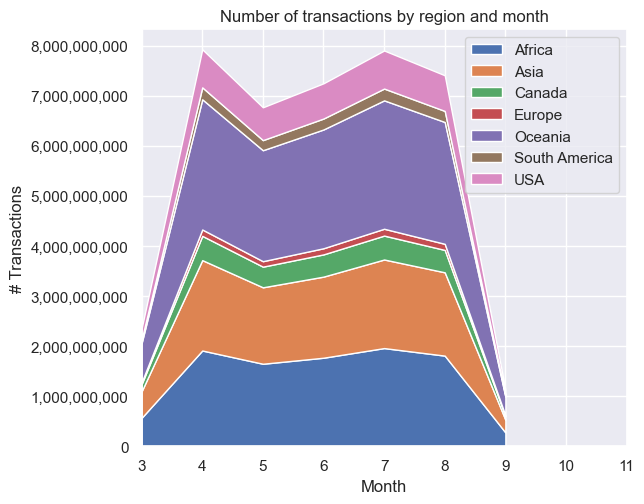

In [15]:
# Visualizing the data
sns.set_theme()
fig, ax = plt.subplots()
ax.stackplot(q5_pivot.index, q5_pivot.AFRICA, q5_pivot.ASIA, q5_pivot.CANADA, q5_pivot.EUROPE, q5_pivot.OCEANIA, q5_pivot["SOUTH AMERICA"], q5_pivot['USA'],
             labels=['Africa','Asia','Canada','Europe','Oceania','South America','USA'])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlim([3, 11])
fig.tight_layout()
plt.legend(loc='upper right')
plt.xlabel('Month')
plt.ylabel('# Transactions')
plt.title('Number of transactions by region and month')
plt.show()

Q6: What is the total count of transactions for each platform?

In [16]:
q6_df = query('''
    SELECT 
        platform, 
        SUM(transactions) AS total_transactions
    FROM clean_weekly_sales
    GROUP BY platform;
''')
q6_df

,platform,total_transactions
0,Shopify,5925169
1,Retail,1081934227


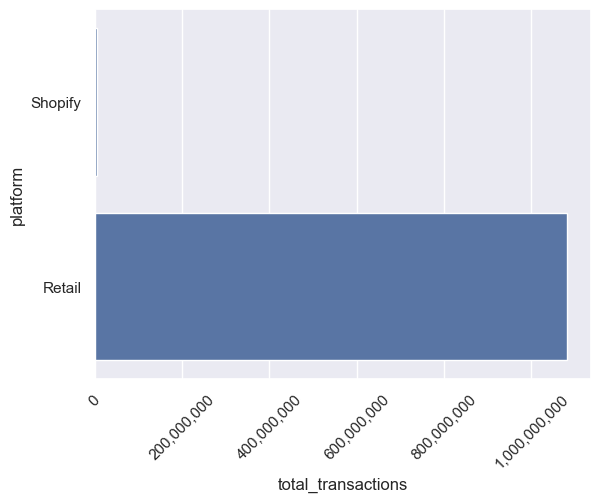

In [17]:
fig, ax = plt.subplots()
ax = sns.barplot(data=q6_df, x='total_transactions', y='platform')
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=45)
plt.show()


Q7: What is the percentage of sales for Retail vs Shopify for each month?

In [18]:
# First create a CTE to get total monthly sales per platform, then use another query to get the percentage
q7_df = query('''
    WITH monthly_transactions AS (
        SELECT 
            calendar_year, 
            month_number, 
            platform, 
            SUM(sales) AS monthly_sales
        FROM clean_weekly_sales
        GROUP BY calendar_year, month_number, platform
    )
    SELECT 
        calendar_year, 
        month_number, 
        ROUND(100 * SUM 
            (CASE 
            WHEN platform = 'Retail' THEN monthly_sales ELSE NULL END) 
            / SUM(monthly_sales),2) AS retail_percentage,
        ROUND(100 * SUM 
            (CASE 
            WHEN platform = 'Shopify' THEN monthly_sales ELSE NULL END)
            / SUM(monthly_sales),2) AS shopify_percentage
    FROM monthly_transactions
    GROUP BY calendar_year, month_number
    ORDER BY calendar_year, month_number
''')
q7_df

,calendar_year,month_number,retail_percentage,shopify_percentage
0,2018.0,3.0,97.92,2.08
1,2018.0,4.0,97.93,2.07
2,2018.0,5.0,97.73,2.27
3,2018.0,6.0,97.76,2.24
4,2018.0,7.0,97.75,2.25
5,2018.0,8.0,97.71,2.29
6,2018.0,9.0,97.68,2.32
7,2019.0,3.0,97.71,2.29
8,2019.0,4.0,97.80,2.20
9,2019.0,5.0,97.52,2.48


- There is a slightly increasing trend for the percentage of shopify transactions while there is a slightly decreasing trend for the percentage of retail transactions.

Q8: What is the percentage of sales by demographic for each year in the dataset?

In [22]:
# Same approach as Q7, but partition by demographic
q8_df = query('''
    WITH demographic_sales AS (
        SELECT 
            calendar_year, 
            demographic, 
            SUM(sales) AS yearly_sales
        FROM clean_weekly_sales
        GROUP BY calendar_year, demographic
    )

    SELECT 
        calendar_year, 
        ROUND(100 * MAX 
            (CASE 
            WHEN demographic = 'Couples' THEN yearly_sales ELSE NULL END)
            / SUM(yearly_sales),2) AS couples_percentage,
        ROUND(100 * MAX 
            (CASE 
            WHEN demographic = 'Families' THEN yearly_sales ELSE NULL END)
            / SUM(yearly_sales),2) AS families_percentage,
        ROUND(100 * MAX 
            (CASE 
            WHEN demographic = 'unknown' THEN yearly_sales ELSE NULL END)
            / SUM(yearly_sales),2) AS unknown_percentage
        FROM demographic_sales
        GROUP BY calendar_year
        ORDER BY calendar_year
''')
q8_df

,calendar_year,couples_percentage,families_percentage,unknown_percentage
0,2018.0,26.38,31.99,41.63
1,2019.0,27.28,32.47,40.25
2,2020.0,28.72,32.73,38.55


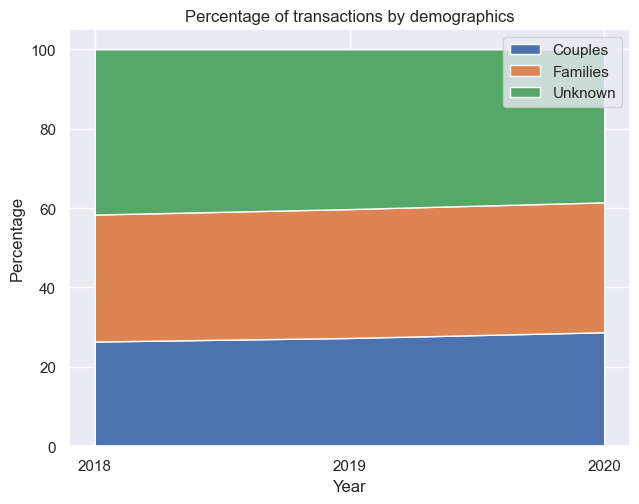

In [25]:
# Visualizing the data
sns.set_theme()
fig, ax = plt.subplots()
ax.stackplot(q8_df.calendar_year, q8_df.couples_percentage, q8_df.families_percentage, q8_df.unknown_percentage,
             labels=['Couples', "Families","Unknown"])
fig.tight_layout()
plt.legend(loc='upper right')
plt.xticks([2018,2019,2020])
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Percentage of transactions by demographics')
plt.show()

- There is a slight increase in the percentage of transactions from families and couples from 2018 to 2020.

Q9: Which age_band and demographic values contribute the most to Retail sales?

In [26]:
q9_df = query('''
    SELECT 
        age_band, 
        demographic, 
        SUM(sales) AS retail_sales,
        ROUND(100 * 
            SUM(sales)::NUMERIC 
            / SUM(SUM(sales)) OVER (),
        1) AS contribution_percentage
    FROM clean_weekly_sales
    WHERE platform = 'Retail'
    GROUP BY age_band, demographic
    ORDER BY retail_sales DESC
''')
q9_df

,age_band,demographic,retail_sales,contribution_percentage
0,unknown,unknown,16067285533,40.5
1,Retirees,Families,6634686916,16.7
2,Retirees,Couples,6370580014,16.1
3,Middle Aged,Families,4354091554,11.0
4,Young Adults,Couples,2602922797,6.6
5,Middle Aged,Couples,1854160330,4.7
6,Young Adults,Families,1770889293,4.5


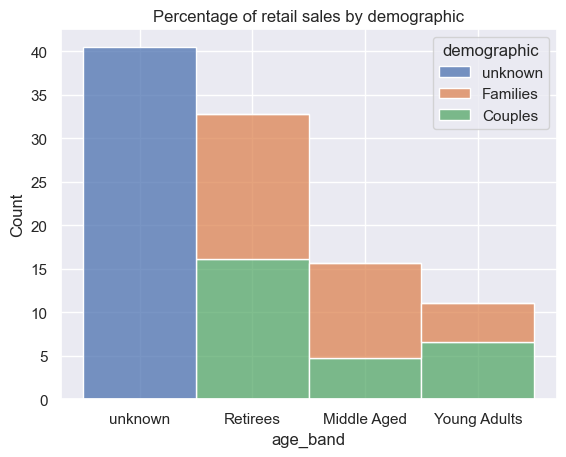

In [31]:
# Visualizing the data
sns.histplot(data=q9_df, x='age_band', weights='contribution_percentage', hue='demographic', multiple='stack')
plt.title('Percentage of retail sales by demographic')
plt.show()

- The majority of the highest retail sales accounting for 40.5% are contributed by unknown age_band and demographic. 
- This is followed by retired families at 16.7% and retired couples at 16.1%.

Q10: Can we use the avg_transaction column to find the average transaction size for each year for Retail vs Shopify? If not - how would you calculate it instead?

In [36]:
query('''
    SELECT 
        calendar_year, 
        platform, 
        ROUND(AVG(avg_transaction),2) AS avg_transaction_row, 
        ROUND(SUM(sales)::NUMERIC / sum(transactions),2) AS avg_transaction_group
    FROM clean_weekly_sales
    GROUP BY calendar_year, platform
    ORDER BY calendar_year, platform;
''')

,calendar_year,platform,avg_transaction_row,avg_transaction_group
0,2018.0,Retail,42.91,36.56
1,2018.0,Shopify,188.28,192.48
2,2019.0,Retail,41.97,36.83
3,2019.0,Shopify,177.56,183.36
4,2020.0,Retail,40.64,36.56
5,2020.0,Shopify,174.87,179.03


- The avg_transaction values are computed in a per row basis, this means each value is dependent on its own transaction.
- This is different with the avg_transaction_group method of calculation that generalizes the transactions and sales for that period and platform before getting the overall average.
- The avg_transaction_group values are more accurate and reliable, though having minimal differences with the first computation method (by row).

**C. Before and After Analysis**

This technique is usually used when we inspect an important event and want to inspect the impact before and after a certain point in time.

Taking the `week_date` value of 2020-06-15 as the baseline week where the Data Mart sustainable packaging changes came into effect.

We would include all `week_date` values for 2020-06-15 as the start of the period after the change and the previous week_date values would be before

Using this analysis approach - answer the following questions:

Q11: What is the total sales for the 4 weeks before and after 2020-06-15? What is the growth or reduction rate in actual values and percentage of sales?

Q12: What about the entire 12 weeks before and after?


Q13: How do the sale metrics for these 2 periods before and after compare with the previous years in 2018 and 2019?


**D. Bonus Question**

Q14: Which areas of the business have the highest negative impact in sales metrics performance in 2020 for the 12 week before and after period?
- region
- platform
- age_band
- demographic
- customer_type

Do you have any further recommendations for Danny’s team at Data Mart or any interesting insights based off this analysis?

**Conclusion**

This case study actually is based off a real life change in Australia retailers where plastic bags were no longer provided for free - as you can expect, some customers would have changed their shopping behaviour because of this change!

Analysis which is related to certain key events which can have a significant impact on sales or engagement metrics is always a part of the data analytics menu. Learning how to approach these types of problems is a super valuable lesson and hopefully these ideas can help you next time you’re faced with a tough problem like this in the workplace!